<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/CONVOLUTIONS_FOR_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONVOLUTIONS FOR IMAGES**

## **1. CANDLESTICK CHARTS**

We described the key element of a convolutional neural network (in short, CNN or ConvNet) that is the convolution operator that maps an input layer with the structure of an image and generates an output layer that is meant to extract relevant features of the image to predict its class.

Our study and description of ConvNets will be illustrated with a specific application. We are going to study the extent to which patterns shown in candlestick charts of stock prices can predict stock returns by processing the plot with a trained ConvNet.

A candlestick is a type of price chart used in technical analysis that displays the high, low, open, and closing prices of a security for a specific period, usually a trading day. The wide part of the candlestick tells whether the closing price was higher or lower than the opening price (black/red if the stock closed lower, white/green if the stock closed higher). A candlestick's shape varies based on the relationship between the day's high, low, opening, and closing prices. The analysis of candlesticks is suitable for liquid financial assets such as stocks, currencies, and futures.

The figure below illustrates the main elements of a candlestick chart that uses a white/black scheme and depicts a day where a security has displayed a negative return (otherwise, the wide part of the candlestick would be white). Candlestick charting then involves drawing sequences of this type of figure to depict the evolution of the price of a security over time. Usually, additional information is included in these charts, such as trading volume during the period.  

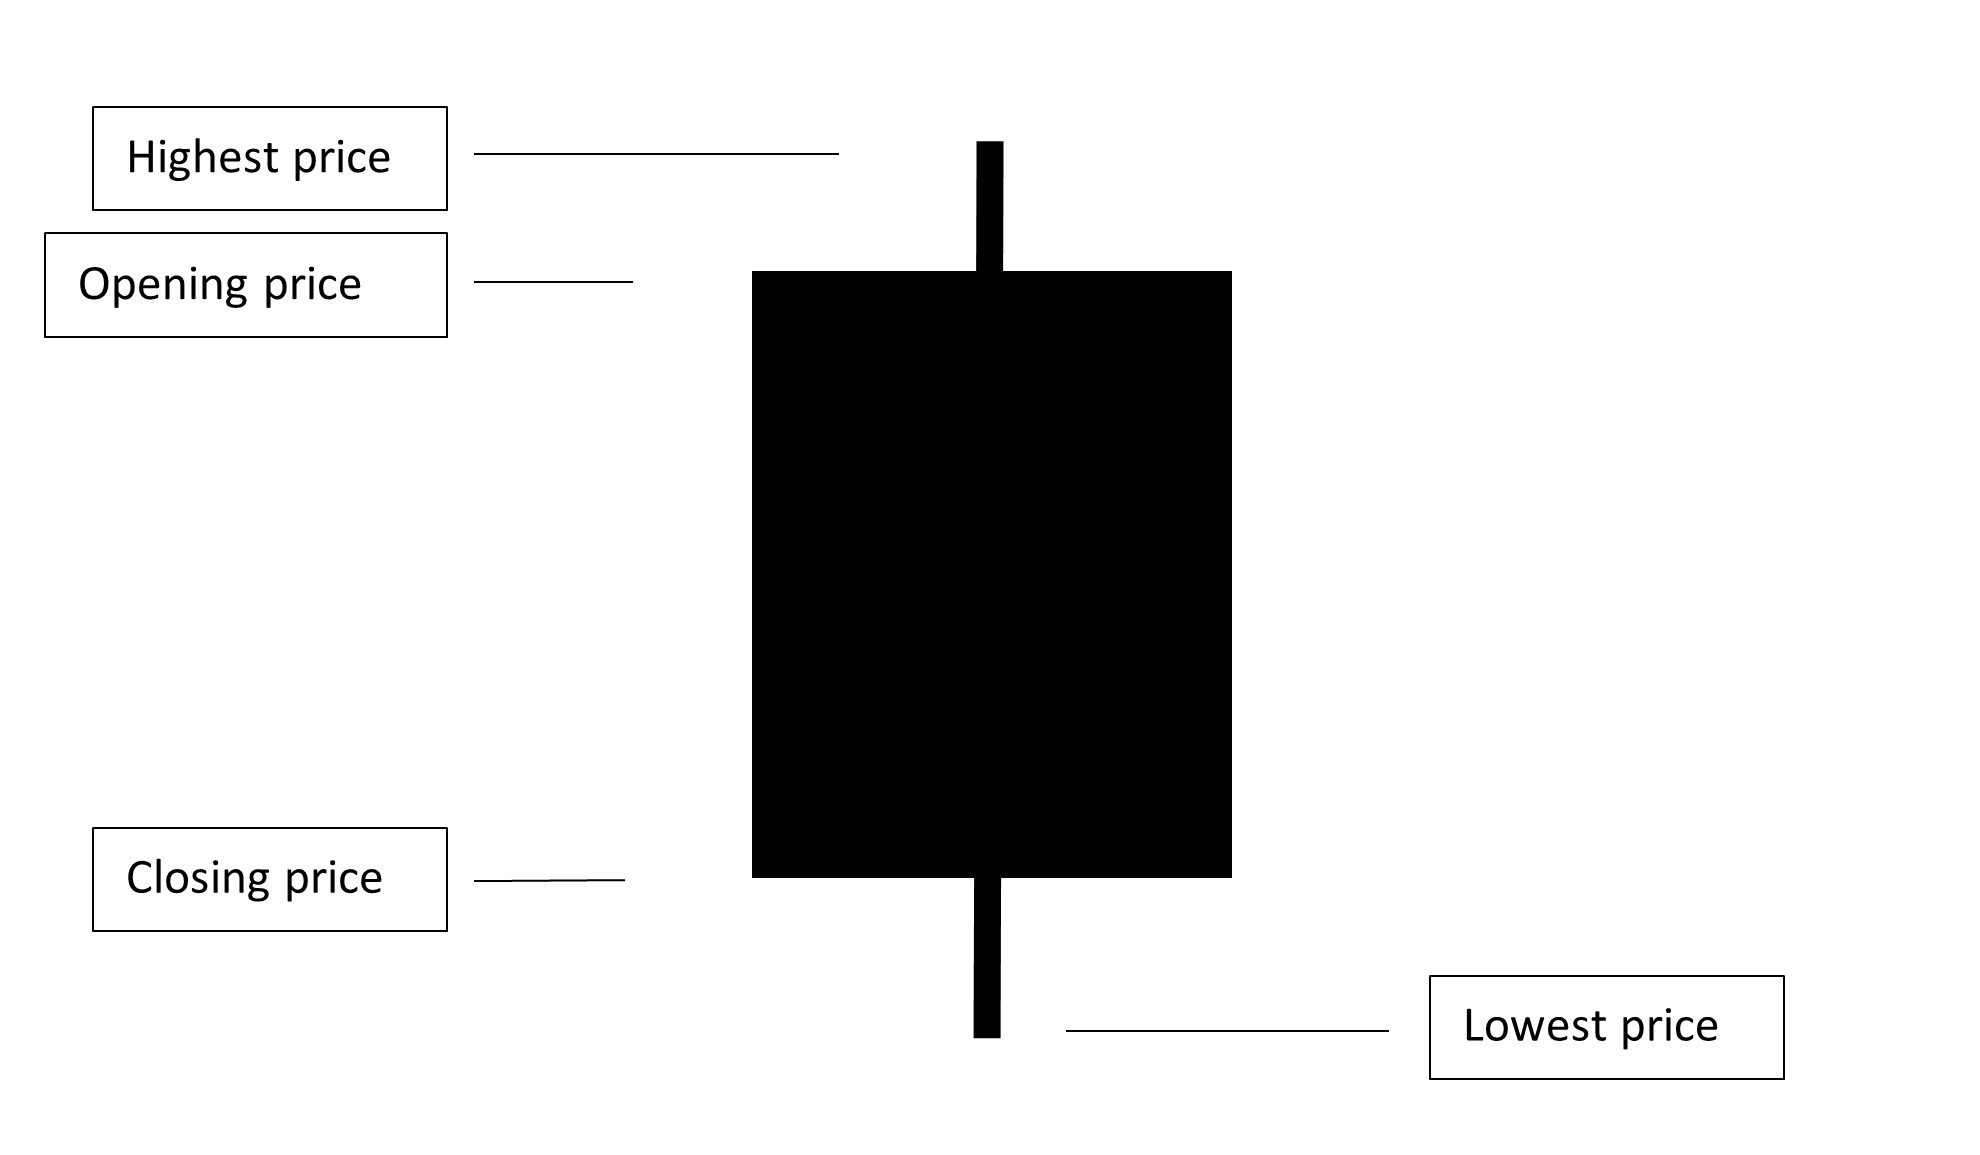

Investors that are so-called technical analysts make their entry and exit trades based on observing patterns from candlestick charts that, according to their knowledge, are able to predict the expected returns of securities over the short and medium run. Their main idea is that patterns displayed by stocks over the recent past reflect investors' sentiment about a security. For instance, long white/green candlesticks indicate strong buying pressures, and technical analysts usually look for trends, supports, and bandwidths that guide their forecasts about future prices. This type of technique, also called "chartism," has identified a large array of different shapes displayed by candlestick charts that are claimed to predict future returns: the "hanging man," the "hammer," the "morning star," the "shoulder-head-shoulder," and so on. The technical analysis community is quite large, although it is frequently ignored by the academic finance community, ([here](https://onlinelibrary.wiley.com/doi/full/10.1111/0022-1082.00265) and [here](https://https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3756587) you can find academic papers that provide systematic studies of technical analysis).

Our objective is to evaluate the extent to which we can train a ConvNet that automatically processes the candlestick plots and identifies those patterns that are relevant for the prediction of returns.

## **2. WORKING WITH CANDLESTICK IMAGES IN PYTHON AND TENSORFLOW-KERAS**

Next, to illustrate the type of information we deal with, we are going to read some candlestick charts from our directory. We have generated more than 1,500 charts from the price evolution of two ETFs, SPY and QQQ, over 20 days. Attached to each chart, there is a label that informs about the 25-day cumulative return that follows the pattern in the plot.

With TensorFlow-Keras, we can read and process images. Below, we load an example of a candlestick pattern that we're going to exploit in our applications. We are use a green/red color scheme to differentiate between "up" and "down" days. The bottom of the chart also includes information about the trading volume during the day.

In [1]:
import tensorflow as tf

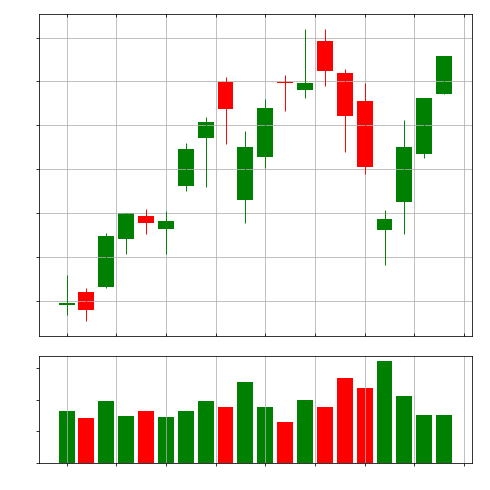

In [2]:
img = tf.keras.utils.load_img("candlestick.png", keep_aspect_ratio="True")
img

Above, we told TensorFlow to read and process the information directly as an image. As we described in lesson 1, ConvNets process images as tensors. To see the structure of these tensors, we can tell TensorFlow to read the image as an array.

The images have a resolution of 490x490 pixels and have three channels (red, green, and blue). Each pixel is then characterized by a three-dimensional vector, where each element takes values between 1 and 255. For instance, a pixel with values (255,255,255) represents a fully-white pixel, a pixel with values (0,0,0) is a fully black pixel, while combinations in the middle capture different combinations among red, green, and blue colors.

In [3]:
img_arr = tf.keras.utils.img_to_array(img)
img_arr.shape

(490, 490, 3)

In [4]:
img_arr

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

We can also opt to read images using a black/white color scheme. Notice that with this transformation we cannot determine if the price went up or down during the day (we would need to further transform the images to fill in the "up" days in white).

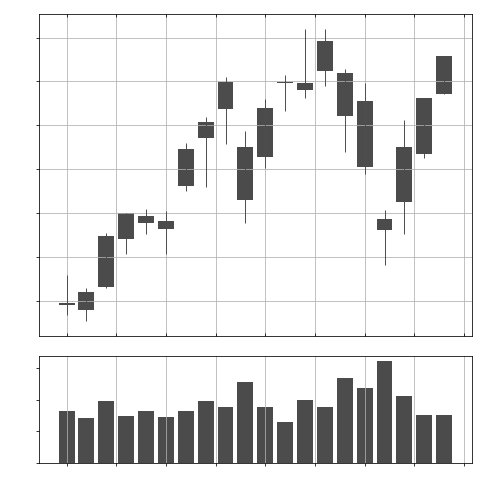

In [5]:
img_grey = tf.keras.utils.load_img(
    "candlestick.png",
    color_mode="grayscale",
)
img_grey

With a black/white color scheme, we keep the same resolution, but we obtain a single channel.

In [6]:
img_arr_grey = tf.keras.utils.img_to_array(img_grey)
img_arr_grey.shape

(490, 490, 1)

## **3. THE CONVOLUTION OPERATOR**

Next, we are going to illustrate and implement the convolution operator in Python. In later lessons, we will exploit tools embedded in TensorFlow-Keras to build convolutional layers, but here, we'll develop them from scratch. For this, we are going to use numpy arrays.

In [7]:
import numpy as np

The block of code below applies a simple convolution operator to a 3$\times$3 array using a 2$\times$2 kernel filter. Before entering the loop, we define the output layer as an array of zeros and fill it with the corresponding values during the iteration. Notice how we slide the kernel over all the elements of the convolution's output.

In [8]:
# Define input and kernel
input = np.array([[1, 1, 1], [0, 1, 0], [1, 0, 1]])
kern = np.array([[1, 2], [0, 1]])
# Initialize the output array of the convolution
convolution = np.zeros(
    (input.shape[0] - kern.shape[0] + 1, input.shape[1] - kern.shape[1] + 1)
)
for j in range(input.shape[1]):  # Loop over width
    if j + kern.shape[1] > input.shape[1]:  # Stop when kernel window exceeds width
        break
    for i in range(input.shape[0]):  # Loop over height
        if i + kern.shape[0] > input.shape[0]:  # Stop when kernel window exceeds height
            break
        # Apply convolution operator
        convolution[i, j] = np.sum(
            kern * input[i : i + kern.shape[0], j : j + kern.shape[1]]
        )
convolution

array([[4., 3.],
       [2., 2.]])

We can use TensorFlow to make the same computations, as we show below. Please check the online documentation for the function tf.nn.conv2d().

In [9]:
input = np.array([[1, 1, 1], [0, 1, 0], [1, 0, 1]])
kern = np.array([[1, 2], [0, 1]])
input0 = np.zeros((1, input.shape[0], input.shape[1], 1))
input0[0, :, :, 0] = input
kern0 = np.zeros((2, 2, 1, 1))
kern0[:, :, 0, 0] = np.array([[1, 2], [0, 1]])
conv_tf = tf.nn.conv2d(input0, kern0, 1, "VALID", data_format="NHWC")
conv_tf_arr = tf.keras.utils.img_to_array(conv_tf[0, :, :, 0])
print(conv_tf_arr)

[[[4.]
  [3.]]

 [[2.]
  [2.]]]


Below, we define a padding function that adds zeros on all sides to an image. The parameter "padding_width" determines how many columns and rows we are adding on each side. For instance, this means that setting "padding_width=0" means no padding, and "padding_width=1" means adding 2 rows and 2 columns of zeros. The function below is general enough to allow multiple input channels.

In [10]:
def add_padding(img, padding_width):
    # Array of zeros of shape (img + padding_width)
    # Check channel dimension
    if img.ndim > 2:
        img_with_padding = np.zeros(
            shape=(
                img.shape[0] + padding_width * 2,  # We add padding on all sides
                img.shape[1] + padding_width * 2,
                img.shape[2],
            )
        )

        for channel in range(img.shape[2]):
            # Change the inner elements
            img_with_padding[
                padding_width:-padding_width, padding_width:-padding_width, channel
            ] = img[:, :, channel]
    else:
        img_with_padding = np.zeros(
            shape=(
                img.shape[0] + padding_width * 2,  # We add padding on all sides
                img.shape[1] + padding_width * 2,
            )
        )
        # Change the inner elements
        img_with_padding[
            padding_width:-padding_width, padding_width:-padding_width
        ] = img[:, :]
    return img_with_padding

The convolution operator then involves making the same operations as above, but for the padded image.

In [11]:
input = np.array([[1, 1], [0, 1]])
kern = np.array([[1, 2], [0, 1]])
pad = 1
input = add_padding(input, pad)
convolution = np.zeros(
    (input.shape[0] - kern.shape[0] + 1, input.shape[1] - kern.shape[1] + 1)
)
for j in range(input.shape[1]):  # Loop over width
    if j + kern.shape[1] > input.shape[1]:  # Stop when kernel window exceeds width
        break
    for i in range(input.shape[0]):  # Loop over height
        if i + kern.shape[0] > input.shape[0]:  # Stop when kernel window exceeds height
            break
        # Apply convolution operator
        convolution[i, j] = np.sum(
            kern * input[i : i + kern.shape[0], j : j + kern.shape[1]]
        )
print(input)
print(kern)
convolution

[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[1 2]
 [0 1]]


array([[1., 1., 0.],
       [2., 4., 1.],
       [0., 2., 1.]])

Let's check that we obtain the same result as using TensorFlow in-built function:

In [12]:
input = np.array([[1, 1], [0, 1]])
kern = np.array([[1, 2], [0, 1]])
input0 = np.zeros((1, input.shape[0], input.shape[1], 1))
input0[0, :, :, 0] = input
kern0 = np.zeros((2, 2, 1, 1))
kern0[:, :, 0, 0] = kern
conv_tf = tf.nn.conv2d(
    input0, kern0, 1, [[0, 0], [1, 1], [1, 1], [0, 0]], data_format="NHWC"
)
print(conv_tf)

tf.Tensor(
[[[[1.]
   [1.]
   [0.]]

  [[2.]
   [4.]
   [1.]]

  [[0.]
   [2.]
   [1.]]]], shape=(1, 3, 3, 1), dtype=float64)


Now, we show how to implement stride, the same horizontally and vertically, in the convolution. This means applying the convolution only in those locations $(i,j)$ in the input layer where both $i$ and $j$ are divisible by the stride parameter.

In [13]:
input = np.array([[1, 1, 1], [1, 0, 1], [0, 1, 0]])
kern = np.array([[1, 2], [0, 1]])
pad = 1
strides = 2
output = [
    np.floor((input.shape[0] - kern.shape[0] + pad + strides) / strides).astype(int),
    np.floor((input.shape[1] - kern.shape[1] + pad + strides) / strides).astype(int),
]
if pad != 0:
    input = add_padding(input, pad)
convolution = np.zeros(output)
for j in range(input.shape[1]):  # Loop over width
    if j + kern.shape[1] > input.shape[1]:  # Stop when kernel window exceeds width
        break
    if j % strides == 0:  # Apply kernel taking into account the stride
        for i in range(input.shape[0]):  # Loop over height
            if (
                i + kern.shape[0] > input.shape[0]
            ):  # Stop when kernel window exceeds height
                break
            if i % strides == 0:  # Apply kernel taking into account the stride
                # Apply convolution operator
                convolution[int(i / strides), int(j / strides)] = np.sum(
                    kern * input[i : i + kern.shape[0], j : j + kern.shape[1]]
                )
convolution

array([[1., 1.],
       [2., 2.]])

And with TensorFlow:

In [14]:
input = np.array([[1, 1, 1], [1, 0, 1], [0, 1, 0]])
kern = np.array([[1, 2], [0, 1]])
input0 = np.zeros((1, input.shape[0], input.shape[1], 1))
input0[0, :, :, 0] = input
kern0 = np.zeros((2, 2, 1, 1))
kern0[:, :, 0, 0] = kern
conv_tf = tf.nn.conv2d(
    input0, kern0, 2, [[0, 0], [1, 1], [1, 1], [0, 0]], data_format="NHWC"
)
print(conv_tf)

tf.Tensor(
[[[[1.]
   [1.]]

  [[2.]
   [2.]]]], shape=(1, 2, 2, 1), dtype=float64)


Finally, we augment the above computations, allowing any arbitrary channel dimension for the input as well as the output. As we shall describe in lesson 3, applying convolutions with multiple input channels implies associating one kernel to each input channel. For each output channel, the convolution operator adds up the results of using each of the kernels in each input channel.

Let's omit the details of this computation and just focus on illustrating the outcome of the operation. After reviewing lesson 3, you can return to this code to understand all the computations.

In [19]:
def convolution_xd(input, kernel, pad=0, stride=1):
    # Determine the size of the output layer
    output = [
        np.floor((input.shape[0] - kernel.shape[0] + 2 * pad + stride) / stride).astype(
            int
        ),
        np.floor((input.shape[1] - kernel.shape[1] + 2 * pad + stride) / stride).astype(
            int
        ),
        kernel.shape[3],
    ]
    # Add padding if necessary
    if pad != 0:
        input = add_padding(input, pad)
    # Initialize the output array of the convolution
    convolution = np.zeros((output[0], output[1], kernel.shape[3]))
    for k in range(kernel.shape[3]):  # Loop over output channels
        for j in range(input.shape[1]):  # Loop over width
            if (
                j + kernel.shape[1] > input.shape[1]
            ):  # Stop when kernel window exceeds width
                break
            if j % stride == 0:  # Apply kernel taking into account the stride
                for i in range(input.shape[0]):  # Loop over height
                    if (
                        i + kernel.shape[0] > input.shape[0]
                    ):  # Stop when kernel window exceeds height
                        break
                    try:
                        if (
                            i % stride == 0
                        ):  # Apply kernel taking into account the stride
                            for h in range(input.shape[2]):  # Loop over input channels
                                # Apply convolution operator in output channel k, summing over input channels h
                                convolution[
                                    int(i / stride), int(j / stride), k
                                ] += np.sum(
                                    kernel[:, :, h, k]
                                    * input[
                                        i : i + kernel.shape[0],
                                        j : j + kernel.shape[1],
                                        h,
                                    ]
                                )
                    except:  # noqa E722
                        break
    return convolution

Below, we define as input image the one we loaded from our sample dataset. We want to obtain a three-dimensional output layer, so we must define a kernel of size kernel height $\times$ kernel width $\times$ input channels $\times$ output channels. In a ConvNet, the elements of this kernel will represent (some of) the trainable parameters that we want to use to predict the label of images.

In [20]:
input = img_arr[..., ::-1]
channels_out = 3
#
kernel = np.zeros((3, 3, input.shape[2], channels_out))
kernel[:, :, 0, 0] = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
kernel[:, :, 0, 1] = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]])
kernel[:, :, 0, 2] = np.array([[1, -1, 1], [1, -10, 1], [1, -1, 1]])
#
kernel[:, :, 1, 0] = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
kernel[:, :, 1, 1] = np.array([[1, 1, 1], [1, -10, 1], [1, 1, 1]])
kernel[:, :, 1, 2] = np.array([[1, -1, 1], [1, 10, 1], [1, -1, 1]])
#
kernel[:, :, 2, 0] = np.array([[-1, -1, -1], [-1, -10, -1], [-1, -1, -1]])
kernel[:, :, 2, 1] = np.array([[1, 1, 1], [1, -10, 1], [1, 1, 1]])
kernel[:, :, 2, 2] = np.array([[1, -1, 1], [1, -10, 1], [1, -1, 1]])
#
convolution = convolution_xd(input, kernel, 4, 3)
convolution.shape

(166, 166, 3)

Below, we show as an array the output layer of this convolution. This is hard to interpret, so below, we also represent as images each of the output layers. Notice that this ad-hoc kernel seems to capture separate information, in each channel, about the "up" moves, "down" moves, and the vertical "edges" of the image.

In [21]:
convolution

array([[[    0.,     0.,     0.],
        [    0.,     0.,     0.],
        [    0.,     0.,     0.],
        ...,
        [    0.,     0.,     0.],
        [    0.,     0.,     0.],
        [    0.,     0.,     0.]],

       [[    0.,     0.,     0.],
        [  255.,  -255., -1785.],
        [-1275.,  1275.,  -255.],
        ...,
        [-1275.,  1275.,  -255.],
        [  255.,  -255., -1785.],
        [    0.,     0.,     0.]],

       [[    0.,     0.,     0.],
        [-1275.,  1275., -1785.],
        [-3570.,  3570.,   510.],
        ...,
        [-3570.,  3570.,   510.],
        [-1275.,  1275., -1785.],
        [    0.,     0.,     0.]],

       ...,

       [[    0.,     0.,     0.],
        [-1275.,  1275., -1785.],
        [-3570.,  3570.,   510.],
        ...,
        [-3570.,  3570.,   510.],
        [-1275.,  1275., -1785.],
        [    0.,     0.,     0.]],

       [[    0.,     0.,     0.],
        [  255.,  -255., -1785.],
        [-1275.,  1275.,  -255.],
        .

## **4. CONCLUSION**

In this notebook, we have set up the ingredients of our stock return prediction model using ConvNets and candlestick charts. Moreover, we have described the basic tools to read and depict an image in Python and we have implemented the convolution operator from scratch.